In [1]:
import xarray as xr
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colormaps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# List and open all files 
files = sorted(glob.glob("/glade/derecho/scratch/gseijo/era5/SST_1980_2024/sst/*.nc"))
ds = xr.open_mfdataset(files, combine='by_coords')

# Convert SST from Kelvin to Celsius
ds['sst'] = ds['sst'] - 273.15
ds = ds.squeeze() #this gets rid of extra dimensions

### Find trimming indices

##### Latitude values for ERA5 are descending, so use ncview to select i and j coordinates and input them below.

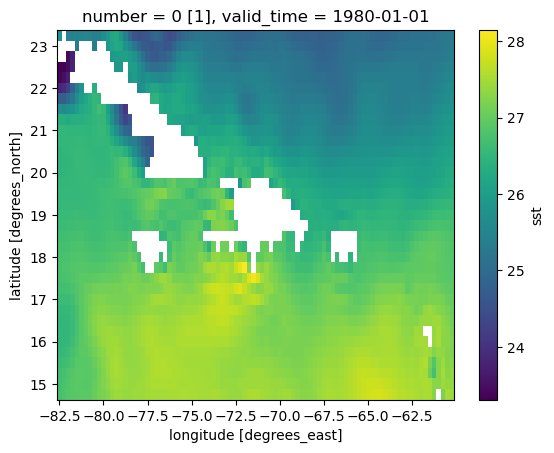

In [3]:
ds['sst'].isel(valid_time=0,latitude=slice(167,202),longitude=slice(70,160)).plot()

## This looks good, let's trim

In [4]:
# Bounding box
lat_min, lat_max = 15., 21.
lon_min, lon_max = -69., -63.

# Apply spatial mask 
ds = ds.isel(latitude=slice(167,202),longitude=slice(70,160))
lats = ds.latitude
lons = ds.longitude
xlen = len(ds.longitude)
ylen = len(ds.latitude)
nday = len(ds.valid_time)

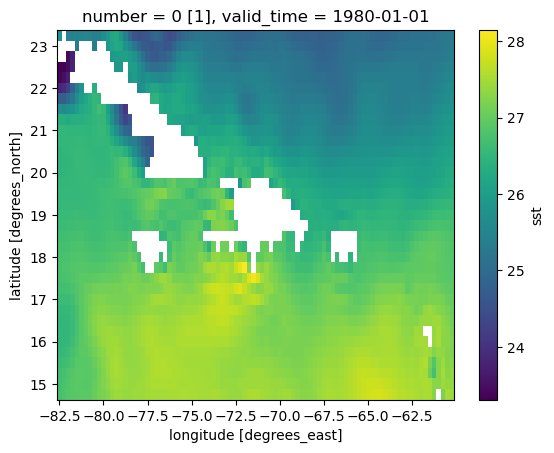

In [6]:
ds['sst'].isel(valid_time=0).plot()

In [7]:
# Resample daily SST to monthly mean SST
ds_mon = ds.resample(valid_time='M').mean(dim='valid_time')
ds_mon

<xarray.Dataset>
Dimensions:     (valid_time: 540, latitude: 35, longitude: 90)
Coordinates:
    number      int64 0
  * latitude    (latitude) float64 23.25 23.0 22.75 22.5 ... 15.25 15.0 14.75
  * longitude   (longitude) float64 -82.5 -82.25 -82.0 ... -60.75 -60.5 -60.25
  * valid_time  (valid_time) datetime64[ns] 1980-01-31 1980-02-29 ... 2024-12-31
Data variables:
    sst         (valid_time, latitude, longitude) float32 dask.array<chunksize=(8, 23, 64), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-07-16T19:07 GRIB to CDM+CF via cfgrib-0.9.1...

## Calculate MMM (Maximum Monthly Mean) for SST at each grid point

In [12]:
# Subset the first 10 years for static climatology
clim_ds = ds_mon.sel(valid_time=ds_mon.valid_time.dt.year.isin(range(1980, 1990)))

# Compute the monthly climatology (average SST for each month over 10 years)
monthly_clim = clim_ds['sst'].groupby('valid_time.month').mean(dim='valid_time')
# Shape: (month=12, lat, lon)

# MMM: max monthly mean across 12 months at each grid cell
MMM = monthly_clim.max(dim='month')

# Next, calculate MMM standard deviation
### collect the max temp over the 10 years of climatology, then find the standard deviation among these values
ymaxes = np.zeros((10,ylen,xlen),dtype=float)
i=0
for y in np.arange(1980,1990,1):
    mon12 = clim_ds.sst.isel(valid_time=slice(i*12,i*12+12))
    ymaxes[i,:,:] = mon12.max(dim='valid_time').values
    i = i + 1

ymaxes = xr.DataArray(ymaxes, dims=('time', 'latitude', 'longitude'), coords={'time': np.arange(1980, 1990), 'latitude': ds_mon.latitude, 'longitude': ds_mon.longitude})

MMM_std = ymaxes.std(dim='time')

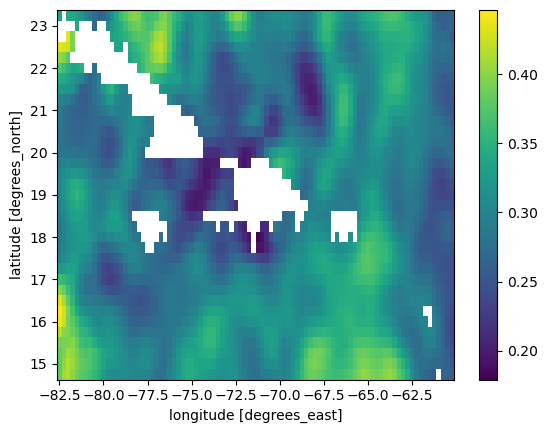

In [13]:
MMM_std.plot()

In [14]:
# Run some checks:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    
    print("Max MMM is ", MMM.max().values)
    print("Min MMM is ", MMM.min().values)
    print("Max MMM_std is ", MMM_std.max().values)
    print("Min MMM_std is ", MMM_std.min().values)

Max MMM is  30.147034
Min MMM is  27.574463
Max MMM_std is  0.4463237194743119
Min MMM_std is  0.17926449675047484


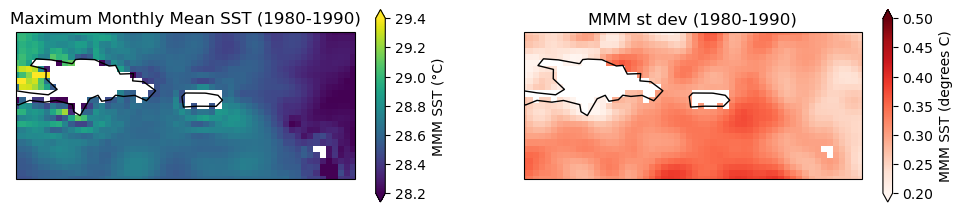

In [15]:
# Plot MMM from static climatology
fig = plt.figure(figsize=(12, 2.5))
ax = fig.add_subplot(1,2,1, projection=ccrs.PlateCarree())
ax.set_extent([lon_min-5, lon_max+2.8, lat_min, lat_max])
ax.set_title("Maximum Monthly Mean SST (1980-1990)")
pc=ax.pcolormesh(ds.longitude, ds.latitude, MMM, cmap='viridis',vmin=28.2,vmax=29.4,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='MMM SST (°C)')

# Plot MMM standard deviation
ax = fig.add_subplot(1,2,2, projection=ccrs.PlateCarree())
ax.set_extent([lon_min-5, lon_max+2.8, lat_min, lat_max])
ax.set_title("MMM st dev (1980-1990)")
pc=ax.pcolormesh(ds.longitude, ds.latitude, MMM_std, cmap='Reds',vmin=0.2,vmax=0.5,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='MMM SST (degrees C)')


## Calculate Degree Heating Weeks (DHW) in 2 ways: 1) using the standard 1°C threshold and 2) using the variability based threshold (2*MMMstd; Boylan & Kleypas 2008)

### first calculate hotspot anomalies

In [18]:
# Define thresholds
threshold1 = MMM + 1
threshold2 = MMM + 2 * MMM_std

# Hotspot anomalies (set values below threshold to 0), also mask land cells 
hs_anoms1 = (ds.sst - threshold1).where(ds.sst > threshold1, other=0).where(ds.sst.isel(valid_time=0) > -10)
hs_anoms2 = (ds.sst - threshold2).where(ds.sst > threshold2, other=0).where(ds.sst.isel(valid_time=0) > -10)

hs_anoms1 = hs_anoms1.load()
hs_anoms2 = hs_anoms2.load()

In [17]:
ds.valid_time[7305].values

numpy.datetime64('2000-01-01T00:00:00.000000000')

In [22]:
%%time

# DHW = 12-week rolling sum, divided by 7 (to get °C-weeks)
DHW1 = hs_anoms1.rolling(valid_time=84, min_periods=84).sum() / 7
DHW2 = hs_anoms2.rolling(valid_time=84, min_periods=84).sum() / 7

DHW1 = xr.DataArray(DHW1,dims=('valid_time','latitude','longitude'))
DHW2 = xr.DataArray(DHW2,dims=('valid_time','latitude','longitude'))

ds['DHW1'] = DHW1
ds['DHW2'] = DHW2

CPU times: user 456 ms, sys: 91.1 ms, total: 548 ms
Wall time: 581 ms


In [23]:
# Run some checks:
print("SST max in 2024 is ", ds.sst.sel(valid_time='2024').max().values)

DHW1_2024 = ds.DHW1.sel(valid_time='2024')
print("DHW1 max is ", DHW1_2024.max().values)

DHW2_2024 = ds.DHW2.sel(valid_time='2024')
print("DHW2 max is ", DHW2_2024.max().values)

SST max in 2024 is  33.316803
DHW1 max is  10.015975952148438
DHW2 max is  16.017068058946816


## Calculate some statistics:
* max_DHW = max DHW per year
* bleach_index = coral bleaching severity based on maximum DHW each year
* bleach_days = number of days with bleaching (DHW >= 4 or bleach index > 1)

In [24]:
%%time

# Extract years from valid_time
years = ds.sst['valid_time'].dt.year

# Group by year
grouped1 = ds.DHW1.groupby(years)
grouped2 = ds.DHW2.groupby(years)

# Maximum DHW per year per coordinate
max_DHW1 = grouped1.max()
max_DHW2 = grouped2.max()

# Convert continuous DHW values into 4 discrete bleaching risk categories using 4°C-weeks interval scale and rounding down with np.floor()
bleach_index1 = np.floor(max_DHW1 / 4) 
bleach_index2 = np.floor(max_DHW2 / 4) 

# Number of days with DHW ≥ 4 per year per coordinate 
bleach_days1 = np.zeros((45,ylen,xlen),dtype=float)
bleach_days2 = np.zeros((45,ylen,xlen),dtype=float)

for y in np.arange(1980,2025,1):
    
    bleach_days1[y-1980,:,:] = np.count_nonzero(grouped1[y] >= 4, axis=0)
    bleach_days2[y-1980,:,:] = np.count_nonzero(grouped2[y] >= 4, axis=0)

bleach_days1 = xr.DataArray(bleach_days1,dims=('year','latitude','longitude'))
bleach_days2 = xr.DataArray(bleach_days2,dims=('year','latitude','longitude'))

bleach_days1 = bleach_days1.where(ds.sst.isel(valid_time=0) > -10)
bleach_days2 = bleach_days2.where(ds.sst.isel(valid_time=0) > -10)

CPU times: user 654 ms, sys: 156 ms, total: 810 ms
Wall time: 843 ms


### Put stats into a Dataset with a year time dimension

In [25]:
# Put into Dataset
ds_bleach = xr.Dataset({
    'max_dhw1' : max_DHW1,
    'max_dhw2' : max_DHW2,
    'bleach_index1': bleach_index1,
    'bleach_index2': bleach_index2,
    'num_days_bleach1': bleach_days1,
    'num_days_bleach2': bleach_days2,
})

### Plot results 

#### Max DHW in 2024 (based on both thresholds)

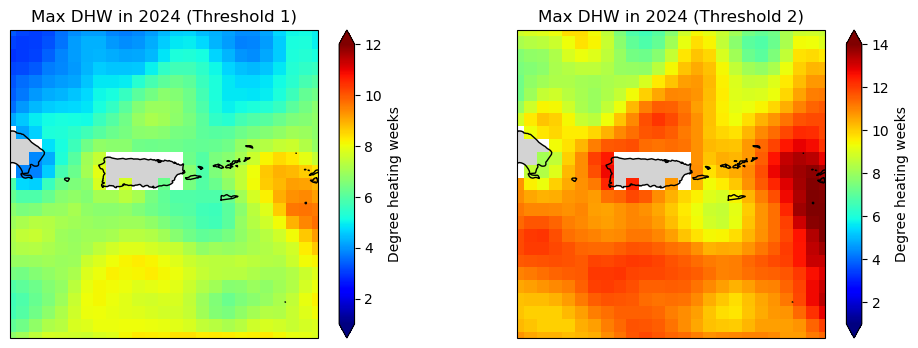

In [26]:
cmap = 'jet'

fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1,2,1, projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
pc=ax.pcolormesh(ds.longitude, ds.latitude, ds_bleach.max_dhw1.sel(year=2024), cmap=cmap,
                 vmin=1,vmax=12,
                 transform=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, color='lightgray')
ax.set_title("Max DHW in 2024 (Threshold 1)")
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Degree heating weeks')


ax = fig.add_subplot(1,2,2, projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

pc=ax.pcolormesh(ds.longitude, ds.latitude, ds_bleach.max_dhw2.sel(year=2024), cmap=cmap,
                 vmin=1,vmax=14,
                 transform=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, color='lightgray')
ax.set_title("Max DHW in 2024 (Threshold 2)")
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Degree heating weeks')


#### Number of bleaching days (based on both thresholds)

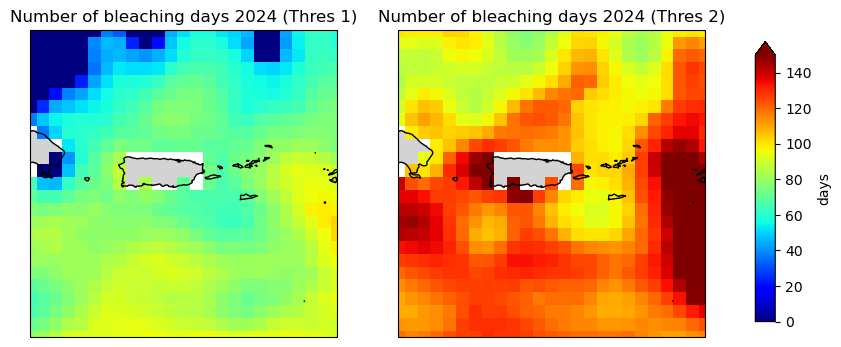

In [27]:
cmap = 'jet'

fig = plt.figure(figsize=(10, 4))

ax = fig.add_subplot(1,2,1, projection=ccrs.PlateCarree())
ax.set_title("Number of bleaching days 2024 (Thres 1)")
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
pc=ax.pcolormesh(lons, lats, ds_bleach.num_days_bleach1.sel(year=2024), cmap=cmap,
                 vmin=0,vmax=150,
                 transform=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, color='lightgray')

ax = fig.add_subplot(1,2,2, projection=ccrs.PlateCarree())
ax.set_title("Number of bleaching days 2024 (Thres 2)")
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
pc=ax.pcolormesh(lons, lats, ds_bleach.num_days_bleach2.sel(year=2024), cmap=cmap,
                 vmin=0,vmax=150,
                 transform=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, color='lightgray')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc, cax=cbar_ax,extend='max',label='days')

#### Check number of bleaching days in 2023 (both thresholds), which should be slightly lower than 2024

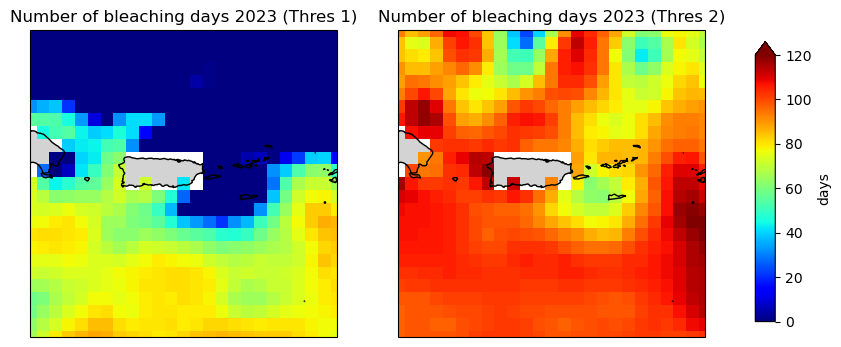

In [28]:
cmap = 'jet'

fig = plt.figure(figsize=(10, 4))

ax = fig.add_subplot(1,2,1, projection=ccrs.PlateCarree())
ax.set_title("Number of bleaching days 2023 (Thres 1)")
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
pc=ax.pcolormesh(lons, lats, ds_bleach.num_days_bleach1.sel(year=2023), cmap=cmap,
                 vmin=0,vmax=120,
                 transform=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, color='lightgray')

ax = fig.add_subplot(1,2,2, projection=ccrs.PlateCarree())
ax.set_title("Number of bleaching days 2023 (Thres 2)")
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
pc=ax.pcolormesh(lons, lats, ds_bleach.num_days_bleach2.sel(year=2023), cmap=cmap,
                 vmin=0,vmax=120,
                 transform=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, color='lightgray')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc, cax=cbar_ax,extend='max',label='days')

#### Check number of bleaching days in 2022 (both thresholds), which should be much lower than 2023 and 2024

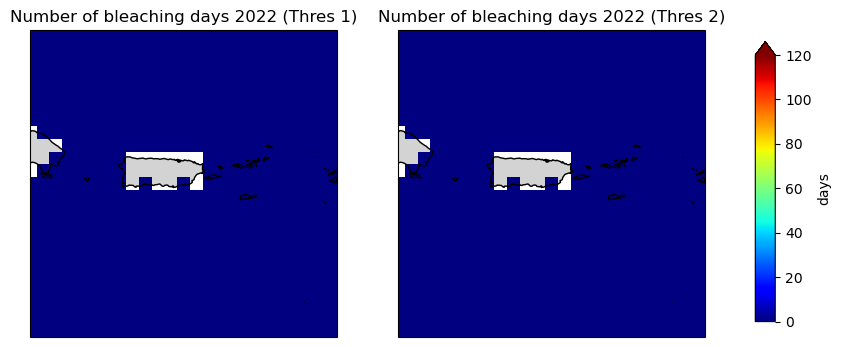

In [29]:
cmap = 'jet'

fig = plt.figure(figsize=(10, 4))

ax = fig.add_subplot(1,2,1, projection=ccrs.PlateCarree())
ax.set_title("Number of bleaching days 2022 (Thres 1)")
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
pc=ax.pcolormesh(lons, lats, ds_bleach.num_days_bleach1.sel(year=2022), cmap=cmap,
                 vmin=0,vmax=120,
                 transform=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, color='lightgray')

ax = fig.add_subplot(1,2,2, projection=ccrs.PlateCarree())
ax.set_title("Number of bleaching days 2022 (Thres 2)")
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
pc=ax.pcolormesh(lons, lats, ds_bleach.num_days_bleach2.sel(year=2022), cmap=cmap,
                 vmin=0,vmax=120,
                 transform=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, color='lightgray')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc, cax=cbar_ax,extend='max',label='days')

#### Check number of bleaching days in 2010 (both thresholds), which should show a small spike near southern Puerto Rico

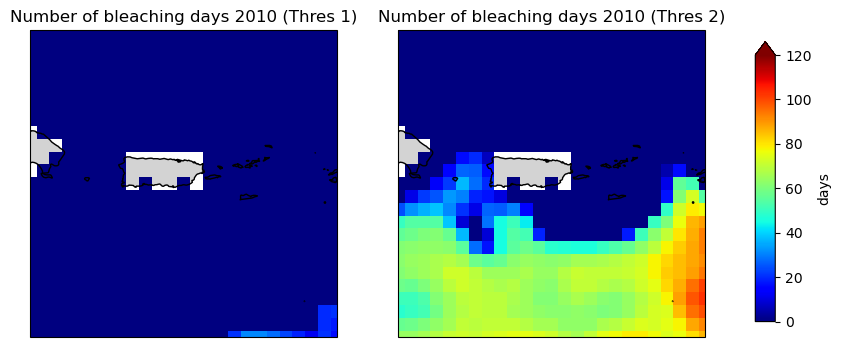

In [30]:
cmap = 'jet'

fig = plt.figure(figsize=(10, 4))

ax = fig.add_subplot(1,2,1, projection=ccrs.PlateCarree())
ax.set_title("Number of bleaching days 2010 (Thres 1)")
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
pc=ax.pcolormesh(lons, lats, ds_bleach.num_days_bleach1.sel(year=2010), cmap=cmap,
                 vmin=0,vmax=120,
                 transform=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, color='lightgray')

ax = fig.add_subplot(1,2,2, projection=ccrs.PlateCarree())
ax.set_title("Number of bleaching days 2010 (Thres 2)")
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
pc=ax.pcolormesh(lons, lats, ds_bleach.num_days_bleach2.sel(year=2010), cmap=cmap,
                 vmin=0,vmax=120,
                 transform=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, color='lightgray')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc, cax=cbar_ax,extend='max',label='days')

#### Check number of bleaching days in 2005 (both thresholds), which should show another small spike near southern Puerto Rico

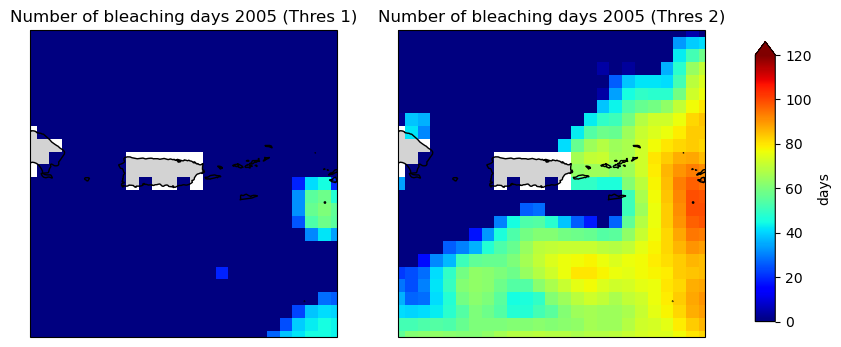

In [31]:
cmap = 'jet'

fig = plt.figure(figsize=(10, 4))

ax = fig.add_subplot(1,2,1, projection=ccrs.PlateCarree())
ax.set_title("Number of bleaching days 2005 (Thres 1)")
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
pc=ax.pcolormesh(lons, lats, ds_bleach.num_days_bleach1.sel(year=2005), cmap=cmap,
                 vmin=0,vmax=120,
                 transform=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, color='lightgray')

ax = fig.add_subplot(1,2,2, projection=ccrs.PlateCarree())
ax.set_title("Number of bleaching days 2005 (Thres 2)")
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
pc=ax.pcolormesh(lons, lats, ds_bleach.num_days_bleach2.sel(year=2005), cmap=cmap,
                 vmin=0,vmax=120,
                 transform=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, color='lightgray')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc, cax=cbar_ax,extend='max',label='days')

### Plot the bleaching index in 2024

In [32]:
colorlist = ['paleturquoise', 'yellow', 'orange', 'red']

cmap = matplotlib.colors.LinearSegmentedColormap.from_list('bleach', colorlist, N=4)

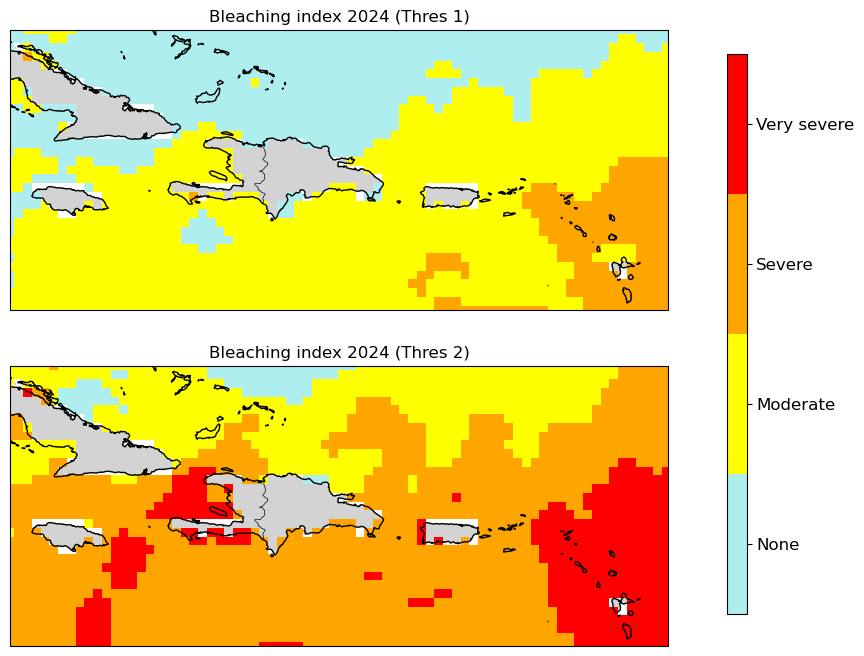

In [33]:
fig = plt.figure(figsize=(10, 8))

ax = fig.add_subplot(2,1,1, projection=ccrs.PlateCarree())
ax.set_title("Bleaching index 2024 (Thres 1)")
ax.set_extent([lon_min-10, lon_max+2.8, lat_min, lat_max+2], crs=ccrs.PlateCarree())
pc=ax.pcolormesh(lons, lats, ds_bleach.bleach_index1.sel(year=2024), cmap=cmap,
                 vmin=0,vmax=4,
                 transform=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, color='lightgray')

ax = fig.add_subplot(2,1,2, projection=ccrs.PlateCarree())
ax.set_title("Bleaching index 2024 (Thres 2)")
ax.set_extent([lon_min-10, lon_max+2.8, lat_min, lat_max+2], crs=ccrs.PlateCarree())
pc=ax.pcolormesh(lons, lats, ds_bleach.bleach_index2.sel(year=2024), cmap=cmap,
                 vmin=0,vmax=4,
                 transform=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, color='lightgray')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, ticks=[0.5,1.5,2.5,3.5], pad=0.03)
cbar.ax.set_yticklabels(['None', 'Moderate', 'Severe', 'Very severe'], fontsize=12) ;

#### Compare to bleaching index in 2010, which was not as severe

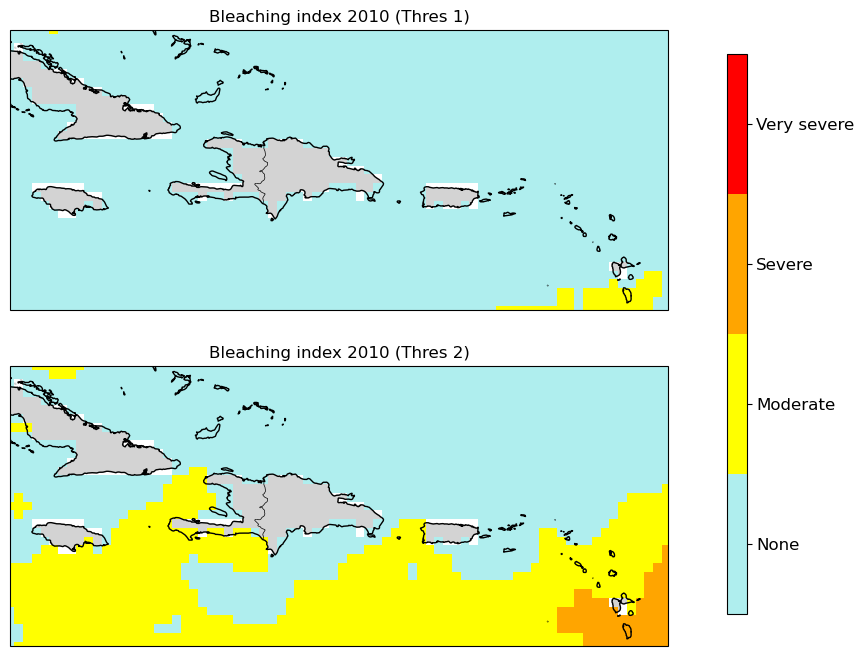

In [25]:
fig = plt.figure(figsize=(10, 8))

ax = fig.add_subplot(2,1,1, projection=ccrs.PlateCarree())
ax.set_title("Bleaching index 2010 (Thres 1)")
ax.set_extent([lon_min-10, lon_max+2.8, lat_min, lat_max+2], crs=ccrs.PlateCarree())
pc=ax.pcolormesh(lons, lats, ds_bleach.bleach_index1.sel(year=2010), cmap=cmap,
                 vmin=0,vmax=4,
                 transform=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, color='lightgray')

ax = fig.add_subplot(2,1,2, projection=ccrs.PlateCarree())
ax.set_title("Bleaching index 2010 (Thres 2)")
ax.set_extent([lon_min-10, lon_max+2.8, lat_min, lat_max+2], crs=ccrs.PlateCarree())
pc=ax.pcolormesh(lons, lats, ds_bleach.bleach_index2.sel(year=2010), cmap=cmap,
                 vmin=0,vmax=4,
                 transform=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, color='lightgray')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, ticks=[0.5,1.5,2.5,3.5], pad=0.03)
cbar.ax.set_yticklabels(['None', 'Moderate', 'Severe', 'Very severe'], fontsize=12) ;